In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import time
import copy
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from sklearn.utils import class_weight

from config_reader import Config
from read_data import read_data
from preproc_data import *
from label_data import label_data
from split_data import split_data
from detection import *

cfg = Config()
%load_ext autoreload
%autoreload 2

In [ ]:
cyclone_events, data = read_data(path='../data')
# Consider renaming first variable
cyclone_events_data, data, metrics = preproc_data(cyclone_events, metrics=data)
labels, events = label_data(cyclone_events_data.ce2)
train_data, test_data, labels_train, labels_test, train_id, test_id = split_data(data, labels, ratio=0.8)

In [ ]:
desc = "DenseNet121"
filename = "DenseNet121.ipynb"
network_name = filename.split('.')[0]
comment = ""

In [ ]:
from show_test_data import show_test_data
import torch
import torch.nn as nn
import numpy as np
from config_reader import Config
from sigma import sigma
import pandas as pd

def get_start_ticks(labels_test):
    labels_test = np.array(labels_test)
    start_ticks = []
    for i in range(len(labels_test) - 1):
        if (labels_test[i] == 0 and labels_test[i+1] == 1):
            start_ticks.append(i+1)
    return np.array(start_ticks)

def predicted_event_id(tick, start_ticks):
    idx = (np.abs(start_ticks - tick)).argmin()
    return idx

def fill_preicted_events(predicted_events, start_ticks, labels_test):
    cfg = Config()
    #res = np.zeros(shape=len(labels_test), dtype=int)
    res = [0] * len(labels_test)
    for k, pr in enumerate(predicted_events):
        if pr == 1:
            for i in range(start_ticks[k], start_ticks[k] + cfg.w):
                res[i] = 1

    res = indices(res, 1)
    return np.array(res, dtype=int)

def indices(lst, item):
    return [i for i, x in enumerate(lst) if x == item]


def test(nn, test_data, labels_test):
    # Test the model
    cfg = Config()
    nn.eval()    
    sigmas = []
    tp_ids = []
    fp_ids = []
    fn_ids = []
    tn_ids = []

    if cfg.mode == 'predict':
        predicted = np.zeros(shape=test_data.shape[2])

    with torch.no_grad():
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for i in range(test_data.shape[2]):
            if (labels_test[i] == 2):
                continue
            image = test_data[:, :, i]
            label = labels_test[i]
            
            image = image.unsqueeze(0) 
            image = image.unsqueeze(0) 
            
            test_output = nn(image)
            #arg = test_output.item()
            #sig = sigma(arg)
            #sigmas.append(sig)
            
            _, pred_y = torch.max(test_output.data, 1)
            # print(f"pred_y {pred_y}")
            # print(f"label {label}")
            #print(sig)
            # 0 - 1 when cyclone is present
            if (pred_y == label and label == 1):
                tp += 1
                tp_ids.append(i)
            # 1 - 0 when no cyclone is present
            elif (pred_y == label and label == 0):
                tn += 1
                tn_ids.append(i)
            # 0 - 1 when no cyclone is present
            elif (pred_y != label and label == 1):
                fn += 1
                fn_ids.append(i)
            # 1 - 0 when cyclone is present
            elif (pred_y != label and label == 0):
                fp += 1
                fp_ids.append(i)
            pass   
        pass
    
    if cfg.mode == 'predict':
        predicted[tp_ids] = 1
        event_start_ticks = get_start_ticks(labels_test)
        predicted_events = np.zeros(shape=len(event_start_ticks))

        for item in tp_ids:
            predicted_event = predicted_event_id(item, event_start_ticks)
            predicted_events[predicted_event] = 1

        tp_ids = fill_preicted_events(predicted_events, event_start_ticks, labels_test)

        tp = predicted_events.sum()
        fn = len(event_start_ticks) - tp
    
        fp = fp // cfg.w
        tn = tn // cfg.w
    return tp, tn, fp, fn, sigmas, (tp_ids, fp_ids, fn_ids, tn_ids)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from show_loss import show_loss
from get_test_stats import get_test_stats
from show_test_data import show_test_data
from sklearn import metrics
from parameters import Stats
from IPython.display import clear_output
from config_reader import Config

'''
Train the network on given data.

nn           - Network to train.
batch_size   - Batch size to apply to data.
num_epochs   - How many epochs to train for.
train_data   - Data to train on.
labels_train - Labels for train_data.
loss_func    - Loss function.
optimizer    - Optimizer for gradients.
draw         - Whether to display loss dynamics.
step_test    - Whether to test on test data after each epoch.
args         - test data and test labels.

It's not recommended to use 'draw' and 'step_test' at the same time.
'''
def train(nn, batch_size, num_epochs, train_data, labels_train_pre, loss_func, optimizer, args, draw=False, step_test=False):  
    nn.train()
    nn = nn.double()
    loss_vals = []
    epoch_loss = []

    labels_train = torch.tensor([(0 if i == 2 else i) for i in labels_train_pre])
    
    test_stats_list = []
    train_stats_list = []

    tprs_test = []
    fprs_test = []
    tprs_train  = []
    fprs_train = []

    fprs_test.append(0)
    tprs_test.append(0)
    fprs_train.append(0)
    tprs_train.append(0)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        iters = int(train_data.shape[2] / batch_size)
        for i in range(iters):
            images = train_data[:, :, i:i + batch_size]
            labels = labels_train[i:i + batch_size]        
            
            b_x = images  
            # Change to Double if doesn't work
            b_y = labels.long()
            
            b_x = b_x.reshape((batch_size, 1, 36, 69))          
                
            optimizer.zero_grad()
            output = nn(b_x)
            #print(output)
            #print(b_y)
            loss = loss_func(input=output, target=b_y)   
            epoch_loss.append(loss.item())
            running_loss += loss.item() * batch_size
            if (draw == True and i != 0 and i % 100 == 0 and not step_test):
                show_loss(epoch_loss, loss_vals)
            elif (draw and i != 0 and i % 100 == 0 and step_test and epoch > 0):
                show_loss(epoch_loss, loss_vals, clear_after=False)
                show_test_data(test_stats_list, train_stats_list)
                clear_output(True)
            elif (draw and i != 0 and i % 100 == 0 and step_test and epoch == 0):
                show_loss(epoch_loss, loss_vals)
            
            loss.backward()                           
            optimizer.step()  

        if (step_test):
            tp, tn, fp, fn, sigmas, _ = test(nn, args[0], args[1])  
            test_stats = get_test_stats(args[0].shape[2], tp, tn, fp, fn, sigmas)          
            test_stats_list.append(test_stats)          

            tp, tn, fp, fn, sigmas, _ = test(nn, train_data, labels_train_pre)  
            train_stats = get_test_stats(args[0].shape[2], tp, tn, fp, fn, sigmas)       
            train_stats_list.append(train_stats)

            show_test_data(test_stats_list, train_stats_list)
            nn.train()
        pass
        loss_vals.append(running_loss / train_data.shape[2])
        
    tprs_test += [item.tpr for item in test_stats_list]
    tprs_train += [item.tpr for item in train_stats_list]
    fprs_test += [item.fpr for item in test_stats_list]
    fprs_train += [item.fpr for item in train_stats_list]

    fprs_test.append(1)
    tprs_test.append(1)
    fprs_train.append(1)
    tprs_train.append(1)

    fprs_test, tprs_test = zip(*sorted(zip(fprs_test, tprs_test)))
    fprs_train, tprs_train = zip(*sorted(zip(fprs_train, tprs_train)))

    # sort by fpr
    auc_test = metrics.auc(fprs_test, tprs_test)
    auc_train = metrics.auc(fprs_train, tprs_train)
    return auc_test, auc_train 


In [ ]:
num_epochs = 40
batch_size = 24


y = torch.tensor(list(labels_train))
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
class_weights=torch.tensor(class_weights, dtype=torch.double)

cnn = models.densenet121(pretrained=True)
cnn.features.conv0 = nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
cnn.classifier = nn.Sequential(
    nn.Linear(in_features=1024, out_features=2, bias=True),
    nn.Softmax(dim=1)
)

crtiterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(cnn.parameters(), lr=0.000001, weight_decay=1e-6)

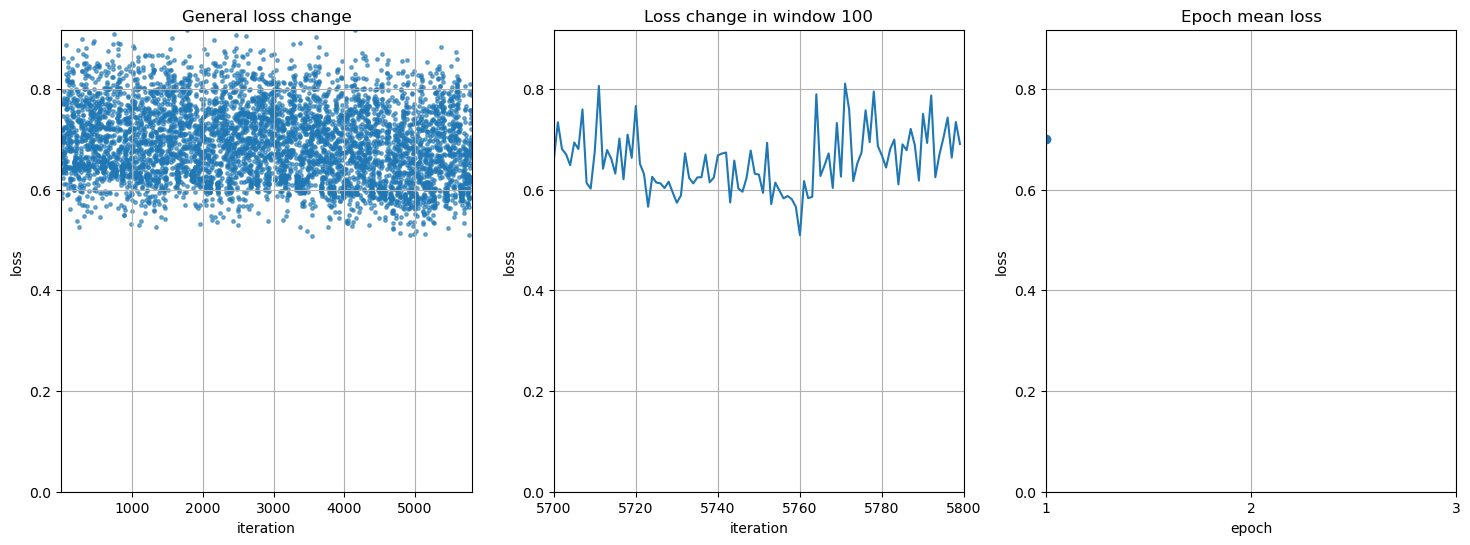

In [9]:
auc_test, auc_train = train(nn=cnn, batch_size=batch_size, num_epochs=num_epochs, train_data=train_data, labels_train_pre=labels_train, loss_func=crtiterion, optimizer=optimizer, args=(test_data, labels_test), draw=False, step_test=True)